In [56]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import matplotlib.gridspec as gridspec
from matplotlib import cm
import string
from numpy import linalg as LA
from scipy.misc import derivative
from scipy.optimize import minimize,root

style.use('seaborn-colorblind')


class agent:
    """
    Agent class encapsulates the information about the position and phenotpye of the agent as well as the agent's current birth and relocation rate.

        Parameters:
            h1 to h5 (float): relocation rate or hopping rate of the agent at resource level 1 to 5, which comprises the agent's phenotype
            x, y (int): the x and y coordinate of the agent's location in the 2-dimensional environment
        Functions:
            updatepos(x,y): update the agent's location to (x,y)
    """

    def __init__(self, hop, x, y):

        self.hop = hop
        self.pos = (x, y)
        self.birth = [0, 1, 2, 3, b5]
        # resource goes as 0, 1, 2, 3, 4
        self.b = self.birth[int(resource[x, y])]
        self.h = self.hop[int(resource[x, y])]

    def updatepos(self, x, y):
        self.pos = (x, y)
        # resource goes as 0, 1, 2, 3, 4
        self.b = self.birth[int(resource[x, y])]
        self.h = self.hop[int(resource[x, y])]

# Figure 1: Schematics
## resource distribution & phenotype schematic

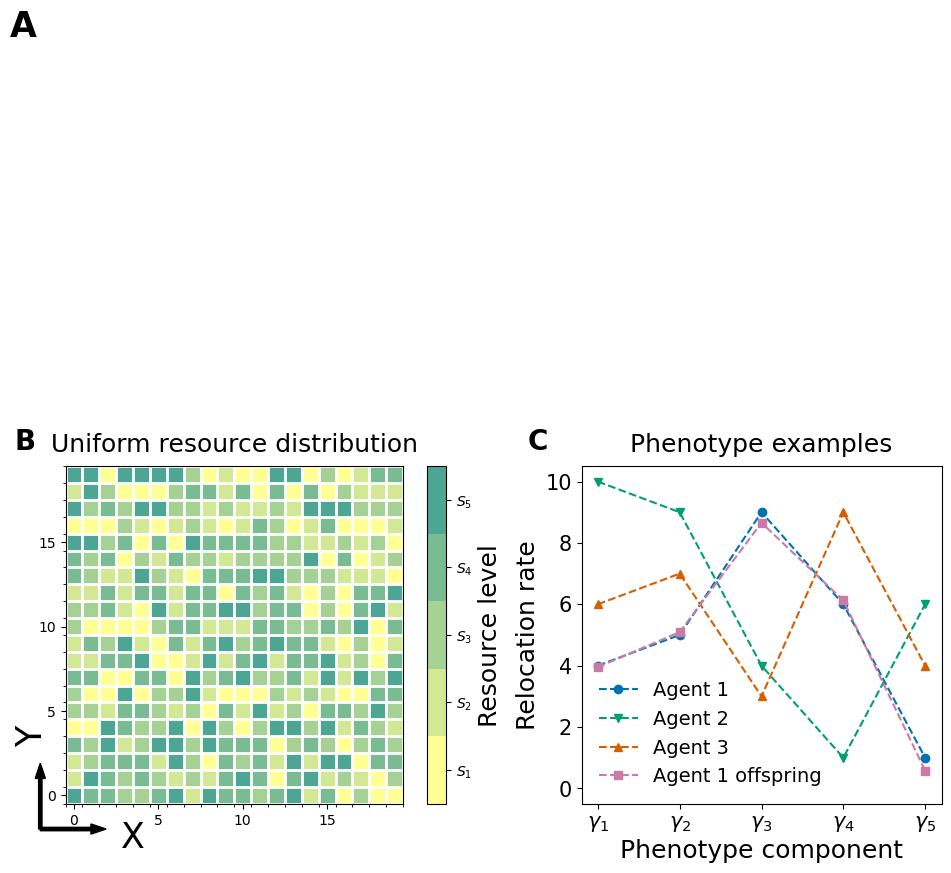

In [182]:
fig = plt.figure(constrained_layout=False, figsize=(9, 7.5),dpi=100)

ax_schematic = plt.subplot(gridspec.GridSpec(1, 1, left=0.1, right=1, top=1, bottom=0.55, wspace=0)[0,0])
ax_schematic.text(-0.15, 1.05, "A", transform=ax_schematic.transAxes,
        size=25, weight='bold')
plt.axis('off')

gs = gridspec.GridSpec(1, 2, width_ratios=[
                       1, 0.05], left=0, right=0.45, top=0.45, bottom=0, wspace=0)
ax = plt.subplot(gs[0, 0])
# Generate data
x = 20
uni_resource = np.random.choice([ 1, 2, 3, 4,5],  size=(x, x))
# Major ticks
ax.set_xticks(np.arange(0, x, 5))
ax.set_yticks(np.arange(0, x, 5))
# Labels for major ticks
ax.set_xticklabels(np.arange(0, x, 5))
ax.set_yticklabels(np.arange(0, x, 5))
# Minor ticks
ax.set_xticks(np.arange(-0.5, x, 1), minor=True)
ax.set_yticks(np.arange(-0.5, x, 1), minor=True)
ax.set_xlim(-0.5,19.5)
ax.set_ylim(-0.5,19.5)
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
im = ax.imshow(uni_resource[0:x, 0:x], interpolation='none',
               origin='lower', alpha=0.7, cmap=cm.get_cmap('summer_r', 5))
ax.set_title("Uniform resource distribution", fontsize=18, pad=10)
ax.set_xlabel("X", fontsize=25)
ax.set_ylabel("Y", fontsize=25)
ax.arrow(-2, -2, 0, 3, clip_on=False, width=0.2, color='k')
ax.arrow(-2, -2, 3, 0, clip_on=False, width=0.2, color='k')
ax.xaxis.set_label_coords(0.2, -0.05)
ax.yaxis.set_label_coords(-0.05, 0.2)
ax.text(-0.15, 1.05, "B", transform=ax.transAxes,
        size=20, weight='bold')
# Color bar axis
ax_cb = plt.subplot(gs[0, 1])
cbar = plt.colorbar(im, cax=ax_cb, ticks=[ 1, 2, 3, 4,5])
cbar.mappable.set_clim(0.5, 5.5)
cbar.set_ticklabels(['$S_1$','$S_2$','$S_3$','$S_4$','$S_5$'])
cbar.set_label('Resource level', fontsize=18)


# Phenotype schematic
gs2 = gridspec.GridSpec(
    1, 1, width_ratios=[1], left=0.6, right=1, top=0.45, bottom=0, wspace=0)
ax2 = plt.subplot(gs2[0, 0])
# noise = np.random.normal(0, 0.2, 5) # reproduction noise, std = 0.2 is for illustration only
noise = [-0.04801385,  0.09379505, -0.34464689,  0.12703898, -0.41765944]
hop = [[4, 5, 9, 6, 1], [10, 9, 4, 1, 6], [6, 7, 3, 9, 4], np.array(
    [4, 5, 9, 6, 1])+noise]  # size of reproduction noise is for illustration purpose only
# for i in range(3):
ax2.plot(hop[0], '--o', label='Agent {}'.format(1))
ax2.plot(hop[1], '--v', label='Agent {}'.format(2))
ax2.plot(hop[2], '--^', label='Agent {}'.format(3))
ax2.plot(hop[3], '--s', label='Agent 1 offspring')
ax2.set_title("Phenotype examples",
              fontsize=18, pad=10)
ax2.text(-0.15, 1.05, "C", transform=ax2.transAxes,
         size=20, weight='bold')
plt.xticks(np.arange(5), ('$\gamma_1$', r'$\gamma_2$',
                          r'$\gamma_3$', r'$\gamma_4$', r'$\gamma_5$'), fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Relocation rate', fontsize=18)
plt.xlabel('Phenotype component', fontsize=18)
plt.ylim(-0.5, 10.5)
plt.legend(loc=3, fontsize=14, frameon=False)

fig.savefig('./Figures/Figure_1_resource_phenotype.pdf', bbox_inches='tight') # save the figure!s

# Figure 2: Stochastic dynamics
## Violin plots at iterations 0, 50, 500, 20000


In [462]:
# mean-field data for b5=5
def cal_average_std(sol, time_steps, hoppings): # at different time steps, time evolution
    
    """
    Calculate the mean and std of hopping rates from the solution of the coupled mean-field equation

    Args:
        sol (array_like): numerical solution of the coupled mean-field equation from ODE solver
        time_steps (int): number of steps
        hoppings (arraly_like): all possible hopping rates in the discretized space

    Returns:
        [tuple of ndarrays]: mean hopping rate and its std at each time step
    """
    fitness = [[np.sum(sol[i][:, t]) for i in range(len(hoppings))]
               for t in range(time_steps)]
    prob = [fitness[t]/np.sum(fitness[t]) for t in range(time_steps)]
    avehop = np.array([np.sum([prob[t][i]*np.array(hoppings[i])
                               for i in range(len(hoppings))], 0) for t in range(time_steps)])
    variance = np.array([np.sum([prob[t][i]*np.array(hoppings[i])**2 for i in range(
        len(hoppings))], 0)-avehop[t]**2 for t in range(time_steps)])
    return avehop, np.sqrt(variance)

x = [0, 2, 4, 6, 8, 10]
hopping_discrete = np.array([p for p in itertools.product(x, repeat=5)])
with open('./evolve_data/mean_field_high_density/density_3', "rb") as fp: # load the low-density mean-field solution
        full_sol = pickle.load(fp)
ave_meanfield,std_meanfield= cal_average_std(full_sol.reshape(-1,5,2001)[:,:,:701],701,hoppings=hopping_discrete) # load first 701 iterations
t_eval= np.linspace(0,700,701)

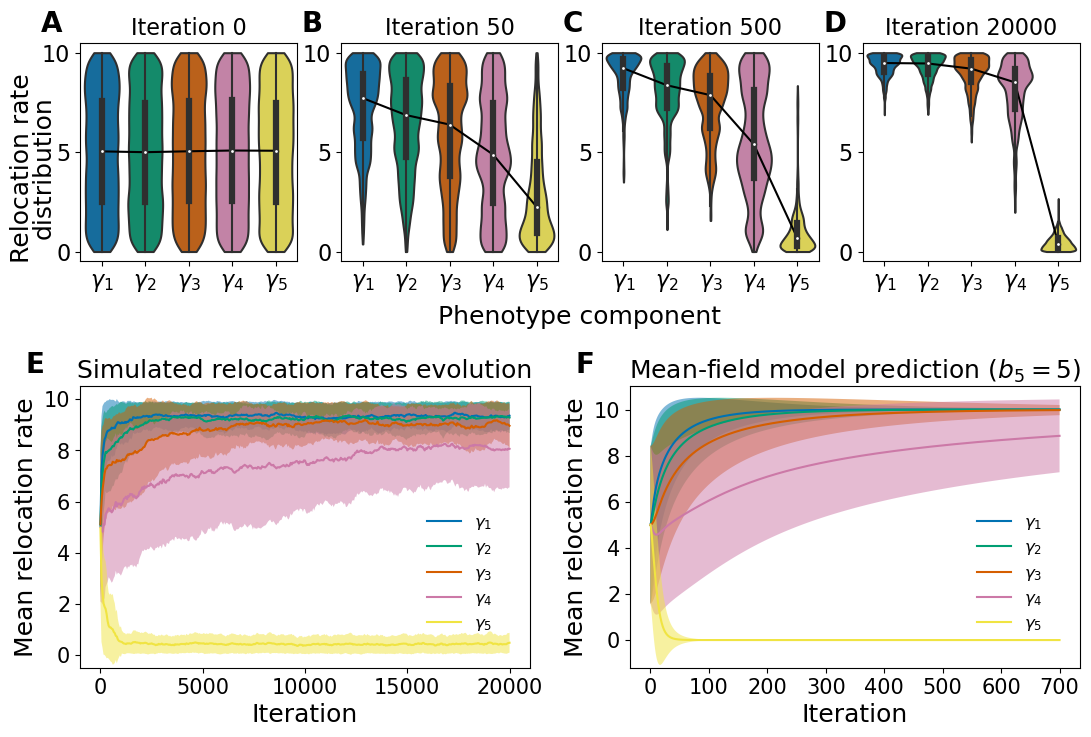

In [536]:
# This cell requires simulation data
df = []
for i in ['00', 50, 500, 20000]:
    data = [[] for _ in range(20)]
    boxdata = []
    for j in range(20):
        try:
            with open("./evolve_data/2021_04_08_21_48/trial_{}/iteration_{}".format(j, i), "rb") as fp:   # Unpickling
                data[j] = pickle.load(fp)
        except FileNotFoundError:
            print("trial_{}".format(j)+" doesn\'t have iteration_{}".format(i))
        else:
            boxdata.append(np.array([data[j][i].hop for i in range(500)]))
    df.append(pd.DataFrame(np.array(boxdata).reshape(10000, 5), columns=(
        '$\gamma_1$', r'$\gamma_2$', r'$\gamma_3$', r'$\gamma_4$', r'$\gamma_5$')))

fig, ax = plt.subplots(ncols=4, nrows=1,
                       gridspec_kw=dict(width_ratios=[1, 1, 1, 1], left=0, right=1, top=1, bottom=0.65), figsize=(10, 6.25), dpi=100)

for i in range(4):
    ax[i].plot(df[i].median(), color='k', label='Simulated')
    sns.violinplot(data=df[i], scale='width', inner='box', cut=0, ax=ax[i])
    ax[i].text(-0.18, 1.05, string.ascii_uppercase[i], transform=ax[i].transAxes,
               size=20, weight='bold')
    ax[i].set_title('Iteration {}'.format(
        [0, 50, 500, 20000][i]), fontsize=16)
#     ax[0, i].set_xlabel("Phenotype component", fontsize=12)
    ax[i].tick_params(axis='x', labelsize=16)
    ax[i].tick_params(axis='y', labelsize=16)
#     if i == 0:
#         ax[ i].set_ylabel("Relocation rate distribution",
#                             color=color, fontsize=12)
fig.text(-0.07, 0.8, 'Relocation rate',
         fontsize=18, va='center', rotation='vertical')
fig.text(-0.048, 0.8, 'distribution',
         fontsize=18, va='center', rotation='vertical')
fig.text(0.5, 0.55, 'Phenotype component', fontsize=18, ha='center')
# get data for 20 trials plot below
iteration =20001
iter_interval=50
std_standard=[[] for _ in range(len(range(0,iteration,iter_interval)))]
ave_standard=[[] for _ in range(len(range(0,iteration,iter_interval)))]
for i in range(0,iteration,iter_interval):
    data=[[] for _ in range(20)]

    boxdata=[]
    for j in range(20):
        try:
            with open("./evolve_data/2021_04_08_21_48/trial_{}/iteration_{}".format(j,i), "rb") as fp:   # Unpickling
                data[j] = pickle.load(fp)
        except FileNotFoundError:
            print("trial_{}".format(j)+" doesn\'t have iteration_{}".format(i))
        else:
            boxdata.append(np.array([data[j][i].hop for i in range(500)]))
    std_standard[int(i/iter_interval)]=np.std(np.vstack(boxdata),0)
    ave_standard[int(i/iter_interval)]=np.mean(np.vstack(boxdata),0)

# gs = ax[1, 0].get_gridspec()
# for i in range(4):
#     ax[1, i].remove()
gs2 = gridspec.GridSpec(
    1, 1, width_ratios=[1], left=0, right=0.45, top=0.45, bottom=0)
# axbig = plt.subplot(gs2[0, 0])
# axbig = fig.add_subplot(gs2[1, :2])
axbig = fig.add_subplot(gs2[0, 0])
gs3 = gridspec.GridSpec(
    1, 1, width_ratios=[1], left=0.55, right=1, top=0.45, bottom=0)
# axbig2 = fig.add_subplot(gs[1, 2:])
axbig2 = fig.add_subplot(gs3[0, 0])
for i in range(5):
    axbig.plot(np.linspace(0, 20000, 401), np.array(ave_standard)[
               :, i], '-', label="$\gamma_{}$".format(i+1))
    axbig.fill_between(np.linspace(0, 20000, 401), np.array(ave_standard)[
                       :, i]-np.array(std_standard)[:, i], np.array(ave_standard)[:, i]+np.array(std_standard)[:, i], alpha=0.5)
axbig.set_ylabel('Mean relocation rate', fontsize=18)
axbig.set_xlabel('Iteration', fontsize=18)
axbig.set_title('Simulated relocation rates evolution', fontsize=18)
axbig.legend(loc='lower right', bbox_to_anchor=(
    0.95, 0.07), frameon=False, fontsize=12)
axbig.set_ylim(-0.5, 10.5)
axbig.set_xticks([0, 5000, 10000, 15000, 20000])
axbig.set_yticks([0, 2, 4, 6, 8, 10])
axbig.tick_params(axis='x', labelsize=15)
axbig.tick_params(axis='y', labelsize=15)
axbig.text(-0.12, 1.05, 'E', transform=axbig.transAxes,
           size=20, weight='bold')


for i in range(5):
    axbig2.plot(t_eval, np.array(ave_meanfield)[
                :, i], label="$\gamma_{}$".format(i+1))
    axbig2.fill_between(t_eval, np.array(ave_meanfield)[:, i]-np.array(std_meanfield)[
                        :, i], np.array(ave_meanfield)[:, i]+np.array(std_meanfield)[:, i], alpha=0.5)
axbig2.set_ylabel('Mean relocation rate', fontsize=18)
axbig2.set_xlabel('Iteration', fontsize=18)
axbig2.set_title('Mean-field model prediction ($b_5=5$)', fontsize=18)
axbig2.legend(loc='lower right', bbox_to_anchor=(
    0.95, 0.07), frameon=False, fontsize=12)
axbig2.set_xticks([0,100,200,300,400,500,600,700])
axbig2.set_yticks([0, 2, 4, 6, 8, 10])
axbig2.set_ylim(-1.2, 11)
axbig2.tick_params(axis='x', labelsize=15)
axbig2.tick_params(axis='y', labelsize=15)
axbig2.text(-0.12, 1.05, 'F', transform=axbig2.transAxes,
            size=20, weight='bold')
fig.savefig('./Figures/Figure_2_evolution_dynamics.pdf', bbox_inches='tight')

# Figure 3: Transition and phase plane
## c=0

In [231]:
iteration =20001
b5_stochastic=[3,3.25,3.5,3.75,4,4.25,4.5,4.75,5,5.25] # uniform
mean_stochastic=[]
std_stochastic=[]
for b5 in b5_stochastic:
    _std_stochastic=[]
    _ave_stochastic=[]
    for i in range(18000,iteration,50): # last 2000 iterations average
        data=[[] for _ in range(20)]
        boxdata=[]
        for j in range(20):
            try:
                with open("./evolve_data/b5_c_plane/detailed/b5_{}_c_0/trial_{}/iteration_{}".format(b5,j,i), "rb") as fp:   # Unpickling
                    data[j] = pickle.load(fp)
            except FileNotFoundError:
                print("trial_{}".format(j)+" doesn\'t have iteration_{}".format(i))
            else:
                boxdata.append(np.array([data[j][i].hop for i in range(500)]))
        _std_stochastic.append(np.std(np.vstack(boxdata),0))
        _ave_stochastic.append(np.mean(np.vstack(boxdata),0))
    
    mean_stochastic.append(np.mean(np.array(_ave_stochastic).T[3,:]))
    std_stochastic.append(np.mean(np.array(_std_stochastic).T[3,:]))


In [220]:
mean_stochastic

[0.8355747487609106,
 1.302288614319111,
 3.9904511634720063,
 6.741468720621307,
 7.549137150982481,
 8.144640036941707,
 8.478887121170962,
 8.488906893205286,
 8.751375198259336,
 8.640671068927789]

In [230]:
mean_stochastic

[0.8355747487609106, 1.3022886143191115]

In [232]:
std_stochastic

[0.7594494763915626,
 1.459594632954016,
 2.8437018579127837,
 2.4198831315260234,
 1.9831561411407268,
 1.4898595542654278,
 1.207260473751383,
 1.2096159665208313,
 1.0545879022728848,
 1.0382316206586575]

In [229]:
std_stochastic

[0.7594494763915626, 1.459594632954016]

In [74]:
import scipy.optimize as opt
def func(x, a, b, c, d):
    return a / (1 + np.exp(-c * (x-d) )) + b


mean_meanfield=[4.3537649780099636e-07, 1.2442809856908339e-05, 0.000275648194462655, 0.0051376398503534685, 0.09980304760631943, 1.9433539737926002, 5.923982336165603, 7.116477747615005, 7.640762716048869, 7.98692993811066, 8.279261452257757, 4.782708437632432]
std_meanfield=[0.000906983985114219, 0.00491239697125021, 0.0235441577903079, 0.10736058816968916, 0.5599859665291492, 2.561692737833099, 2.2564125302822235, 1.5702422994556449, 1.2749981573429414, 1.146810224516724, 1.106891476140216, 2.718991766960965]
b5_meanfield=[3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5, 5.25, 5.5, 4.4]
(a_s, b_s, c_s,d_s), _ = opt.curve_fit(func, b5_stochastic,mean_stochastic,p0=[0,1,1,1])
(a_m, b_m, c_m,d_m), _ = opt.curve_fit(func, b5_meanfield,mean_meanfield,p0=[0,1,1,1])

## c=0.5

In [234]:
iteration =20001
b5_stochastic_exp=[3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18] # uniform
mean_stochastic_exp=[]
std_stochastic_exp=[]
for b5 in b5_stochastic_exp:
    _std_stochastic=[]
    _ave_stochastic=[]
    for i in range(18000,iteration,50): # last 5000 iterations average
        data=[[] for _ in range(20)]
        boxdata=[]
        for j in range(20):
            try:
                with open("./evolve_data/b5_c_plane/detailed/b5_{}_c_0.5/trial_{}/iteration_{}".format(b5,j,i), "rb") as fp:   # Unpickling
                    data[j] = pickle.load(fp)
            except FileNotFoundError:
                print("trial_{}".format(j)+" doesn\'t have iteration_{}".format(i))
            else:
                boxdata.append(np.array([data[j][i].hop for i in range(500)]))
        _std_stochastic.append(np.std(np.vstack(boxdata),0))
        _ave_stochastic.append(np.mean(np.vstack(boxdata),0))
    
    mean_stochastic_exp.append(np.mean(np.array(_ave_stochastic).T[3,:]))
    std_stochastic_exp.append(np.mean(np.array(_std_stochastic).T[3,:]))

In [76]:
import scipy.optimize as opt
def func(x, a, b, c, d):
    return a / (1 + np.exp(-c * (x-d) )) + b
mean_meanfield_exp=[4.569717018891358e-09, 6.0368153131970736e-06, 0.004372515661512843, 1.2925613773924414, 4.842727340273152, 7.630972873699262, 8.830223403547468, 9.292050448738056, 9.531059476460602]
std_meanfield_exp=[9.056691919526321e-05, 0.003401920140112634, 0.10223646535084566, 2.435244137570728, 3.4386777382944786, 2.3881626669638134, 1.5916662104898822, 1.2087140726048455, 0.971031429326318]
b5_meanfield_exp=[4, 6, 8, 10, 10.8, 12, 14, 16, 18]
(a_s, b_s, c_s,d_s), _ = opt.curve_fit(func, b5_stochastic_exp,mean_stochastic_exp,p0=[0,1,1,1])
(a_m, b_m, c_m,d_m), _ = opt.curve_fit(func, b5_meanfield_exp,mean_meanfield_exp,p0=[0,1,1,1])


## Phase plane
### Stochastic

In [235]:
ave = []
for c in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    for b5 in [3, 4, 5, 6, 7, 8, 9, 10,11,12,13,14,15,16]:
        boxdata = []
        for i in range(20):
            data = [[] for _ in range(20)]
            try:
                with open("./evolve_data/b5_c_plane/b5_{}_c_{}/trial_{}/iteration_{}".format(b5, c, i, 20000), "rb") as fp:   # Unpickling
                    data[i] = pickle.load(fp)
            except FileNotFoundError:
                print("trial_{}".format(j) +
                      " doesn\'t have iteration_{}".format(i))
            else:
                boxdata.append(np.average(
                    np.array([data[i][j].hop for j in range(500)]), axis=0))

        ave.append(np.average(np.array(boxdata).T, 1))


def derivative_h4(b5):
    '''Calculate the derivative of max eigenvalue wrt. gamma_4 at gamma_4=5'''
    b = [0, 1, 2, 3, b5]
    def max_eigen(h4):
        h = [10, 10, 10, h4, 0]
        m = np.outer(w, np.array(b)+np.array(h))-np.diag(h)
        return np.max(LA.eig(m)[0])
    return derivative(max_eigen, 5, dx=1e-8).real

root_b5_5 = []
for c in np.linspace(-0.1, 0.7, 80):
    p = [np.exp(-i*c) for i in range(5)]
    w = p/np.sum(p)
    root_b5_5.append(root(derivative_h4, 8, method='df-sane').x) # find the root of b5 that makes the derivative 0, thus the transition point
    

/home/tong/anaconda3/envs/evolution/lib/python3.9/site-packages/scipy/optimize/_spectral.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sigma_k = np.vdot(s_k, s_k) / np.vdot(s_k, y_k)


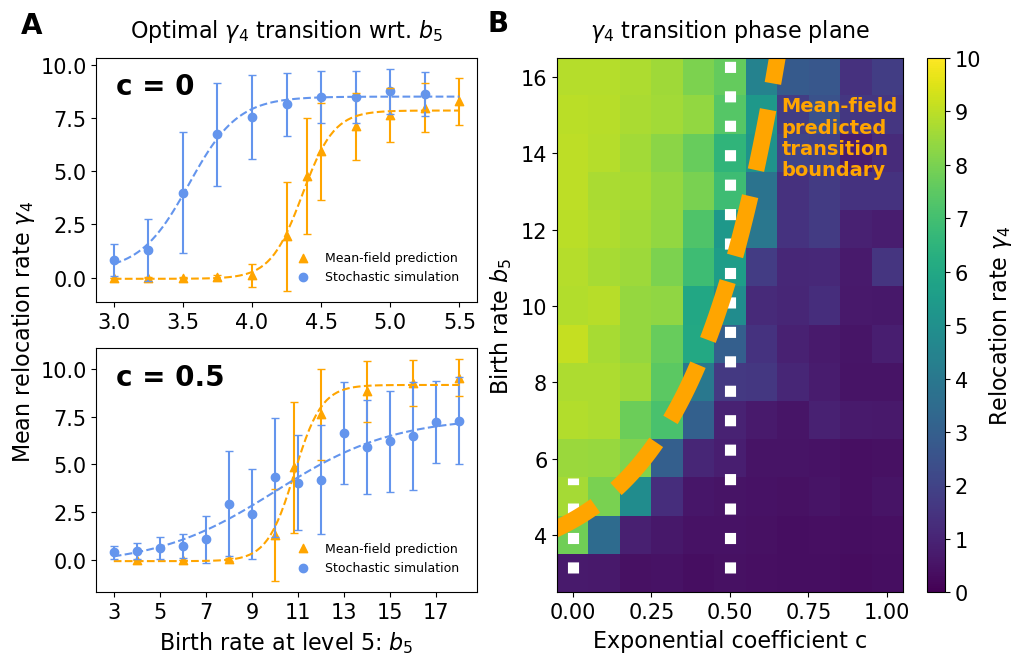

In [236]:
# color to be distinct from colorbar, warm color

fig, ax = plt.subplots(2, 2, constrained_layout=True,
                       gridspec_kw=dict(width_ratios=[1.1, 1], height_ratios=[1, 1]), figsize=(10, 6.5), dpi=100)
gs = ax[1, 0].get_gridspec()
for i in range(2):
    ax[i, 1].remove()
axbig = fig.add_subplot(gs[:, 1])

(a_s, b_s, c_s, d_s), _ = opt.curve_fit(
    func, b5_stochastic, mean_stochastic, p0=[0, 1, 1, 1])
(a_m, b_m, c_m, d_m), _ = opt.curve_fit(
    func, b5_meanfield, mean_meanfield, p0=[0, 1, 1, 1])

color_mf = 'orange'
color_sc = 'cornflowerblue'

ax[0, 0].scatter(b5_meanfield, mean_meanfield, marker='^',
                 color=color_mf, label='Mean-field prediction')
ax[0, 0].errorbar(b5_meanfield, mean_meanfield, yerr=std_meanfield,
                  capsize=3, linestyle='None', color=color_mf)
ax[0, 0].plot(np.linspace(3, 5.5, 100), [func(i, a_m, b_m, c_m, d_m)
                                         for i in np.linspace(3, 5.5, 100)], '--', color=color_mf)

ax[0, 0].scatter(b5_stochastic, mean_stochastic,
                 label='Stochastic simulation', color=color_sc)
ax[0, 0].errorbar(b5_stochastic, mean_stochastic, yerr=std_stochastic,
                  capsize=3, linestyle='None', color=color_sc)
ax[0, 0].plot(np.linspace(3, 5.5, 100), [func(i, a_s, b_s, c_s, d_s)
                                         for i in np.linspace(3, 5.5, 100)], '--', color=color_sc)
ax[0, 0].tick_params(axis='x', labelsize=15)
ax[0, 0].tick_params(axis='y', labelsize=15)

ax[0, 0].legend(frameon=False, fontsize=9, loc='lower left',
                bbox_to_anchor=(0.48, 0.03))
ax[0, 0].set_title(
    "Optimal $\gamma_4$ transition wrt. $b_5$", fontsize=16, pad=15)
ax[0, 0].set_xticks([3, 3.5, 4, 4.5, 5, 5.5])
ax[0, 0].set_yticks([0, 2.5, 5, 7.5, 10])
ax[0, 0].text(-0.2, 1.1, 'A', transform=ax[0, 0].transAxes,
              size=20, weight='bold')
ax[0, 0].text(0.05, 0.85, 'c = 0', transform=ax[0, 0].transAxes,
              size=20, weight='bold')
(a_s, b_s, c_s, d_s), _ = opt.curve_fit(
    func, b5_stochastic_exp, mean_stochastic_exp, p0=[0, 1, 1, 1])
(a_m, b_m, c_m, d_m), _ = opt.curve_fit(
    func, b5_meanfield_exp, mean_meanfield_exp, p0=[0, 1, 1, 1])

ax[1, 0].scatter(b5_meanfield_exp, mean_meanfield_exp, marker='^',
                 color=color_mf, label='Mean-field prediction')
ax[1, 0].errorbar(b5_meanfield_exp, mean_meanfield_exp,
                  yerr=std_meanfield_exp, capsize=3, linestyle='None', color=color_mf)
ax[1, 0].plot(np.linspace(3, 18, 100), [func(i, a_m, b_m, c_m, d_m)
                                        for i in np.linspace(3, 18, 100)], '--', color=color_mf)

ax[1, 0].scatter(b5_stochastic_exp, mean_stochastic_exp,
                 label='Stochastic simulation', color=color_sc)
ax[1, 0].errorbar(b5_stochastic_exp, mean_stochastic_exp,
                  yerr=std_stochastic_exp, capsize=3, linestyle='None', color=color_sc)
ax[1, 0].plot(np.linspace(3, 18, 100), [func(i, a_s, b_s, c_s, d_s)
                                        for i in np.linspace(3, 18, 100)], '--', color=color_sc)

ax[1, 0].tick_params(axis='x', labelsize=15)
ax[1, 0].tick_params(axis='y', labelsize=15)

ax[1, 0].legend(frameon=False, fontsize=9, loc='lower left',
                bbox_to_anchor=(0.48, 0.03))

ax[1, 0].set_yticks([0, 2.5, 5, 7.5, 10])
ax[1, 0].set_xlabel('Birth rate at level 5: $b_5$', fontsize=16, labelpad=5)
ax[1, 0].set_xticks([3, 5, 7, 9, 11, 13, 15, 17])
ax[1, 0].text(0.05, 0.85, 'c = 0.5', transform=ax[1, 0].transAxes,
              size=20, weight='bold')

fig.text(-0.005, 0.5, 'Mean relocation rate $\gamma_4$',
         fontsize=16, va='center', rotation='vertical')

axbig.set_xlim(-0.05, 1.05)
axbig.set_ylim(2.5, 16.5)
im = axbig.imshow(np.array(ave)[:, -2].reshape(11, 14).T, interpolation='none',
                  extent=[-0.05, 1.05, 2.5, 16.5], aspect='auto', origin='lower')
axbig.plot(np.linspace(-0.1, 0.7, 80), np.array(root_b5_5),
           '--', color='orange', linewidth=12)

axbig.set_xlabel('Exponential coefficient c', fontsize=16, labelpad=5)
axbig.set_ylabel('Birth rate $b_5$', fontsize=16, labelpad=5)

cbar = fig.colorbar(im, ticks=np.linspace(-1, 10, 12), aspect=30)
cbar.mappable.set_clim(0, 10)
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Relocation rate $\gamma_4$', fontsize=16)
axbig.tick_params(axis='x', labelsize=15)
axbig.tick_params(axis='y', labelsize=15)
axbig.vlines(x=0, ymin=3, ymax=5.5, color='w',
             linestyles='dotted', linewidth=8)
axbig.vlines(x=0.5, ymin=3, ymax=18, color='w',
             linestyles='dotted', linewidth=8)
axbig.text(-0.2, 1.05, 'B', transform=axbig.transAxes,
           size=20, weight='bold')
# axbig.text(0.54, 0.65, 'Mean-field predicted', transform=axbig.transAxes,
#            size=9.5,color=color_mf, weight='bold')
# axbig.text(0.54, 0.62, 'transition boundary', transform=axbig.transAxes,
#            size=9.5,color=color_mf, weight='bold')

axbig.text(0.65, 0.9, 'Mean-field', transform=axbig.transAxes,
           size=14, color=color_mf, weight='bold')
axbig.text(0.65, 0.86, 'predicted', transform=axbig.transAxes,
           size=14, color=color_mf, weight='bold')
axbig.text(0.65, 0.82, 'transition', transform=axbig.transAxes,
           size=14, color=color_mf, weight='bold')
axbig.text(0.65, 0.78, 'boundary', transform=axbig.transAxes,
           size=14, color=color_mf, weight='bold')

axbig.set_title("$\gamma_4$ transition phase plane", fontsize=16, pad=15)

fig.savefig('./Figures/Figure_3_transition.pdf', bbox_inches='tight')

### Mean-field (supplementary?)

4.385056888355387
2.99999173026448


/home/tong/anaconda3/envs/evolution/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


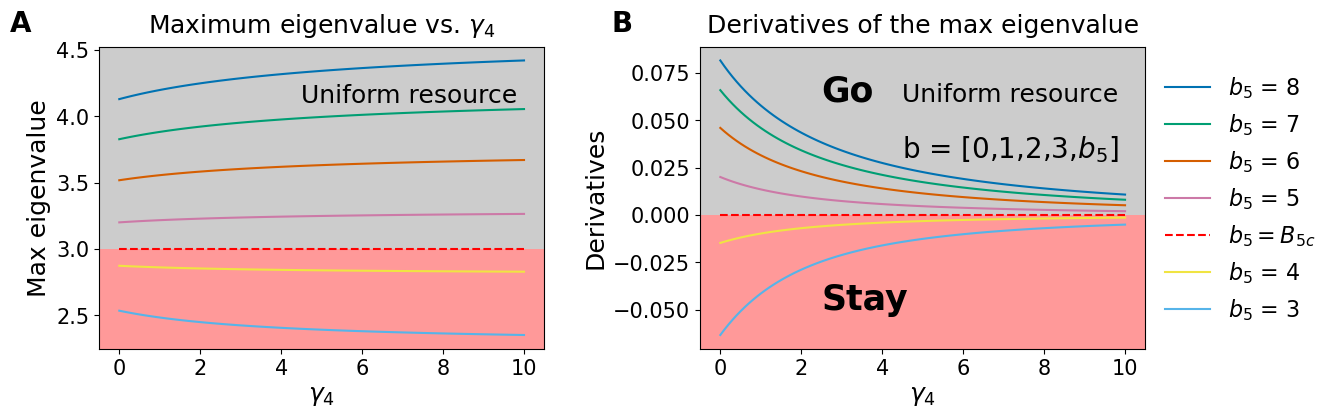

In [459]:
def deri(h4):
    def max_eigen(h4):
        b = [0, 1, 2, 3, b5]
        h = [10, 10, 10, h4, 0.001]
        m = np.array([[w[j]*(b[i]+h[i]) for i in range(5)]
                      for j in range(5)])-np.diag(h)
        return np.max(LA.eig(m)[0])
    return derivative(max_eigen, h4, dx=1e-8).real
def deri_root(b5):
    def max_eigen(h4):
        b = [0, 1, 2, 3, b5]
        h = [10, 10, 10, h4, 0.001]
        m = np.array([[w[j]*(b[i]+h[i]) for i in range(5)]
                      for j in range(5)])-np.diag(h)
        return np.max(LA.eig(m)[0])
    return derivative(max_eigen, 5, dx=1e-8).real
def max_eigen(h4):
    b = [0, 1, 2, 3, b5]
    h = [10, 10, 10, h4, 0.001]
    m = np.array([[w[j]*(b[i]+h[i]) for i in range(5)]
                  for j in range(5)])-np.diag(h)
    return np.max(LA.eig(m)[0])
c = 0
p = [np.exp(-i*c) for i in range(1, 6)]
w = p/np.sum(p)

fig,ax = plt.subplots(1,2,dpi=100,figsize=(13.5,4),gridspec_kw=dict(width_ratios=[1, 1],wspace=0.35))


b5=root(deri_root, 4, method='df-sane').x
max_eigen_critial=max_eigen(5)
print(b5)
print(max_eigen_critial)
for b5 in np.linspace(3, 8, 6)[::-1]:
    maxeign = []
    for h4 in np.linspace(0, 10, 100):
        maxeign.append(max_eigen(h4))
    ax[0].plot(np.linspace(0, 10, 100), maxeign,
            label='$b_5$ = {}'.format(b5))
    if b5 == 5:
        ax[0].plot(np.linspace(0, 10, 100), [max_eigen_critial]*100, '--r', label='$b_5$ = $b_{5\_critical}$')
        
# ax[0].legend(frameon=False, fontsize=18,
#           loc='lower left', bbox_to_anchor=(1, -0.03))
ax[0].set_ylim(*ax[0].get_ylim())
ax[0].axhspan(3.0017180476774152, ax[0].get_ylim()[-1], facecolor='black', alpha=0.2)
ax[0].axhspan(ax[0].get_ylim()[0], 3.0017180476774152, facecolor='red', alpha=0.4)
# ax[0].legend(frameon=False, fontsize=18,
#           loc='lower left', bbox_to_anchor=(1, -0.03))
ax[0].text(4.5, 4.1, 'Uniform resource', fontsize=18)
# ax[0].text(5,3.35, 'Go', fontsize=25,color='blue',weight='bold')
# ax[0].text(5, 2.5, 'Stay', fontsize=25,color='black',weight='bold')
ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].set_title('Maximum eigenvalue vs. $\gamma_4$',
             fontsize=18, pad=10)
ax[0].set_xlabel('$\gamma_4$', fontsize=18)
ax[0].set_ylabel('Max eigenvalue', fontsize=18)
ax[0].text(-0.2, 1.05, 'A', transform=ax[0].transAxes,
           size=20, weight='bold')



for b5 in np.linspace(3, 8, 6)[::-1]:
    derivatives = []
    for h4 in np.linspace(0, 10, 100):
        derivatives.append(deri(h4))
    ax[1].plot(np.linspace(0, 10, 100), derivatives,
            label='$b_5$ = {:.0f}'.format(b5))
    if b5 == 5:
        ax[1].plot(np.linspace(0, 10, 100), [
                0]*100, '--r', label='$b_5=B_{5c}$')
ax[1].set_ylim(*ax[1].get_ylim())
ax[1].axhspan(0, ax[1].get_ylim()[-1], facecolor='black', alpha=0.2)
ax[1].axhspan(ax[1].get_ylim()[0], 0, facecolor='red', alpha=0.4)
ax[1].legend(frameon=False, fontsize=16,
          loc='lower left', bbox_to_anchor=(1, 0.02))
ax[1].text(4.5, 0.06, 'Uniform resource', fontsize=18)
ax[1].text(4.5, 0.03, 'b = [0,1,2,3,$b_5$]', fontsize=20)
ax[1].text(2.5, 0.06, 'Go', fontsize=25,color='black',weight='bold')
ax[1].text(2.5, -0.05, 'Stay', fontsize=25,color='black',weight='bold')
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)
ax[1].set_title('Derivatives of the max eigenvalue',
             fontsize=18, pad=10)
ax[1].text(-0.2, 1.05, 'B', transform=ax[1].transAxes,
           size=20, weight='bold')
plt.xlabel('$\gamma_4$', fontsize=18)
plt.ylabel('Derivatives', fontsize=18)

fig.savefig('./Figures/Supplementary_max_eigen.pdf', bbox_inches='tight')

# Figure 4: high density
## Stochastic simulation

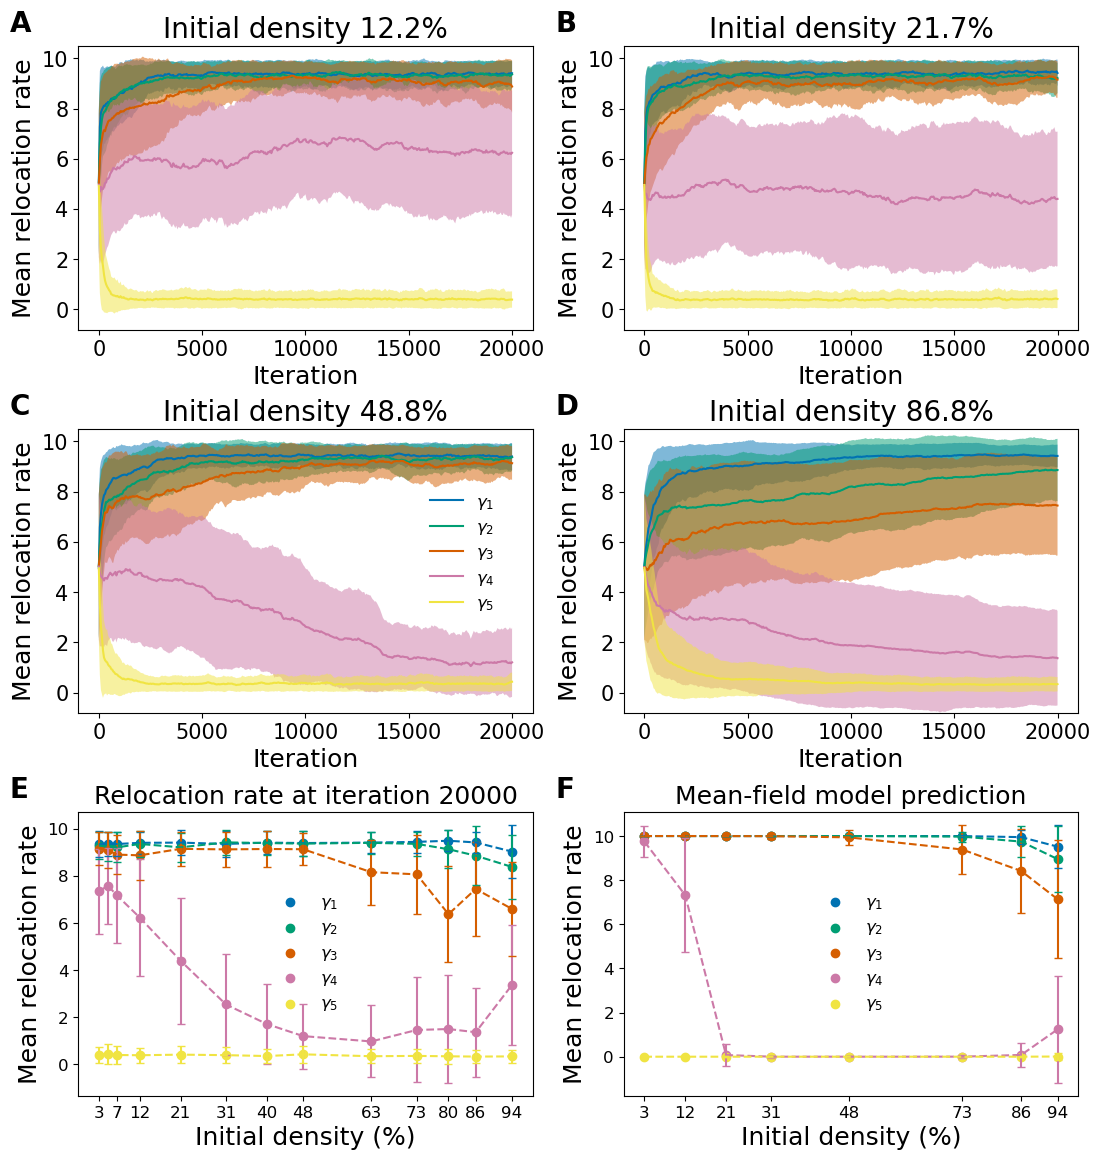

In [219]:
x = [i for i in [0,2,4,6,8,10]]
hopping_discrete=np.array([p for p in itertools.product(x, repeat=5)])
def cal_ave_std_last_step(sol,hoppings=hopping_discrete): # at last time step
    density_total=np.sum(np.array(sol)[:,-1].reshape(7776,5),1)
    prob = density_total/np.sum(density_total)
    avehop = np.sum([prob[i]*np.array(hoppings[i])
                               for i in range(len(hoppings))], 0)
    variance = np.array(np.sum([prob[i]*np.array(hoppings[i])**2 for i in range(
        len(hoppings))], 0)-avehop**2)
    return (avehop,np.sqrt(variance))


fig, ax = plt.subplots(3, 2, gridspec_kw=dict(width_ratios=[1, 1], height_ratios=[
                       1, 1, 1], left=0, right=1, top=1, bottom=0, hspace=0.35, wspace=0.2), dpi=100, figsize=(10, 10.5))
iter_interval = 50
for k in range(4):
    density = [12, 21, '48_rerun_2', 86][k]
    density_ = [12.2, 21.7, 48.8, 86.8][k]
    iteration = 20001
    std = [[] for _ in range(len(range(0, iteration, iter_interval)))]
    ave = [[] for _ in range(len(range(0, iteration, iter_interval)))]
    for i in range(0, iteration, iter_interval):
        data = [[] for _ in range(20)]

        boxdata = []
        for j in range(20):
            try:
                with open("./evolve_data/high_density/density_{}/trial_{}/iteration_{}".format(density, j, i), "rb") as fp:   # Unpickling
                    data[j] = pickle.load(fp)
            except FileNotFoundError:
                print("trial_{}".format(j) +
                      " doesn\'t have iteration_{}".format(i))
            else:
                boxdata.append(np.array([data[j][i].hop for i in range(500)]))
        std[int(i/iter_interval)]=np.std(np.vstack(boxdata),0)
        ave[int(i/iter_interval)]=np.mean(np.vstack(boxdata),0)

    for i in range(5):
        ax[k//2, k % 2].plot(np.linspace(0, 20000, int(np.ceil(iteration/iter_interval))),
                             np.array(ave)[:, i], '-', label="$\gamma_{}$".format(i+1))
        ax[k//2, k % 2].fill_between(np.linspace(0, 20000, int(np.ceil(iteration/iter_interval))), np.array(
            ave)[:, i]-np.array(std)[:, i], np.array(ave)[:, i]+np.array(std)[:, i], alpha=0.5)
        if k == 2:
            ax[k//2, k % 2].legend(loc='lower right', bbox_to_anchor=(
    0.95, 0.3), frameon=False, fontsize=12)
    ax[k//2, k % 2].set_ylabel('Mean relocation rate', fontsize=18)
    ax[k//2, k % 2].set_xlabel('Iteration', fontsize=18)
    ax[k//2, k % 2].set_title('Initial density {}%'.format(density_),
                              fontsize=20)
    ax[k//2, k % 2].text(-0.15, 1.05, string.ascii_uppercase[k], transform=ax[k//2, k % 2].transAxes,
                         size=20, weight='bold')
    ax[k//2, k % 2].set_ylim(-0.8, 10.5)
    ax[k//2, k % 2].set_xticks([0, 5000, 10000, 15000, 20000])
    ax[k//2, k % 2].tick_params(axis='x', labelsize=15)
    ax[k//2, k % 2].tick_params(axis='y', labelsize=15)
    


ave_density = []
std_density = []
density = [int(50000/n/n)
           for n in [128, 96, 80, 64, 48, 40, 35, 32, 28, 26, 25, 24, 23]]
for i in density:
    data = [[] for _ in range(20)]
    boxdata = []
    if i == 48:
        i = '48_rerun_2'
    for j in range(20):
        try:
            with open("./evolve_data/high_density/density_{}/trial_{}/iteration_20000".format(i, j), "rb") as fp:   # Unpickling
                data[j] = pickle.load(fp)
        except FileNotFoundError:
            print("trial_{}".format(j)+" doesn\'t have iteration_{}".format(i))
        else:
            boxdata.append(np.array([data[j][i].hop for i in range(500)]))
    std_density.append(np.std(np.vstack(boxdata),0))
    ave_density.append(np.mean(np.vstack(boxdata),0))

for i in range(5):
    ax[2, 0].scatter(density, np.array(ave_density)[:, i],
                     label="$\gamma_{}$".format(i+1))
    ax[2, 0].errorbar(density, np.array(ave_density)[:, i],
                      yerr=np.array(std_density)[:, i], capsize=3,linestyle='--')
ax[2, 0].set_xticks([3, 7, 12, 21, 31, 40, 48, 63, 73, 80, 86, 94])
ax[2, 0].tick_params(axis='both', which='major', labelsize=12)
ax[2, 0].set_xlabel('Initial density (%)', fontsize=18)
ax[2, 0].set_ylabel('Mean relocation rate', fontsize=18)
ax[2, 0].set_title('Relocation rate at iteration 20000', fontsize=18)
ax[2, 0].text(-0.15, 1.05, 'E', transform=ax[2, 0].transAxes,
              size=20, weight='bold')
ax[2, 0].legend(frameon=False, fontsize=12)

ax[2, 1].set_title('Mean-field model prediction', fontsize=18)
ave_mf_density=[]
std_mf_density=[]
density=[]
for M in [i**2 for i in [128,64,48,40,32,26,24,23]]:
    with open('./evolve_data/mean_field_high_density/density_{}'.format(int(50000/M)), "rb") as fp: 
        full_sol=pickle.load(fp)
    _ave,_std = cal_ave_std_last_step(full_sol)
    ave_mf_density.append(_ave)
    std_mf_density.append(_std)
    density.append(int(50000/M))
for i in range(5):
    ax[2, 1].scatter(density,np.array(ave_mf_density).T[i],label='$\gamma_{}$'.format(i+1))
    ax[2, 1].errorbar(density,np.array(ave_mf_density).T[i],yerr=np.array(std_mf_density).T[i], capsize=3, linestyle='--')
ax[2, 1].legend(frameon=False,fontsize=12)
ax[2, 1].set_xticks(density)
ax[2, 1].tick_params(axis='both', which='major', labelsize=12)
ax[2, 1].set_xlabel('Initial density (%)', fontsize=18)
ax[2, 1].set_ylabel('Mean relocation rate', fontsize=18)
ax[2, 1].text(-0.15, 1.05, 'F', transform=ax[2, 1].transAxes,
              size=20, weight='bold')
fig.savefig('./Figures/Figure_4_density.pdf', bbox_inches='tight')

# Figure 5: mean-field high density phenotype evolution

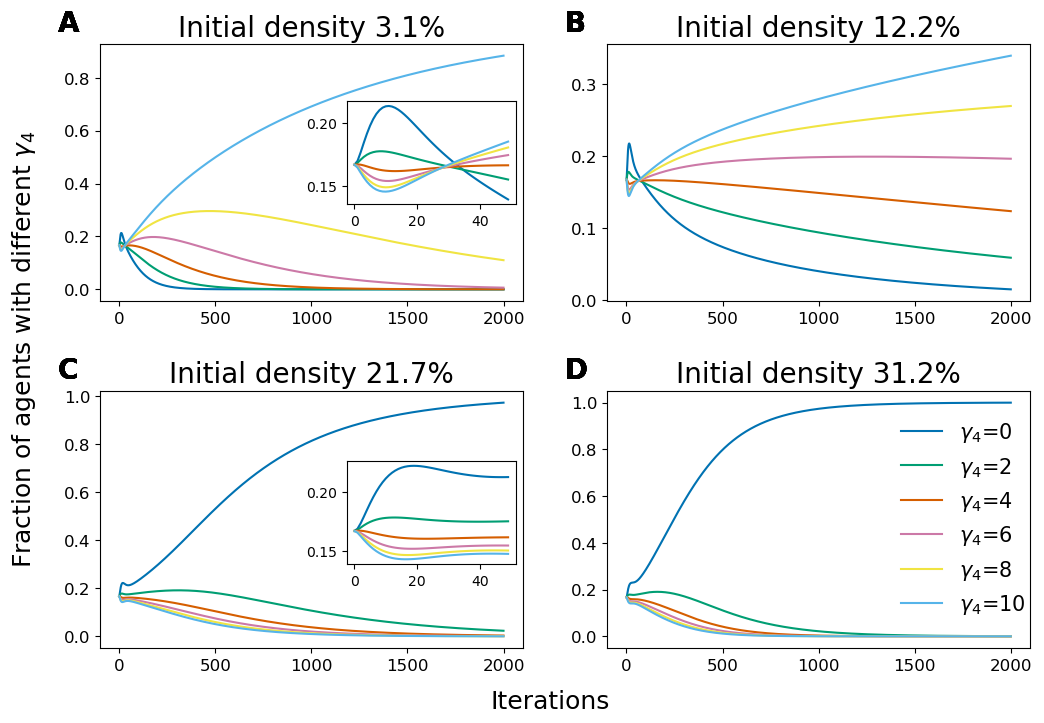

In [284]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig, ax = plt.subplots(2, 2, dpi=100, figsize=(12, 8), gridspec_kw=dict(width_ratios=[1, 1], height_ratios=[
                       1, 1],hspace=0.35, wspace=0.2))
axins = inset_axes(ax[0,0], width="40%", height="40%", loc=4,bbox_to_anchor=(0,0.35,1,1),bbox_transform=ax[0,0].transAxes)
axins2 = inset_axes(ax[1,0], width="40%", height="40%", loc=4,bbox_to_anchor=(0,0.3,1,1),bbox_transform=ax[1,0].transAxes)
# axins3 = inset_axes(ax[1,1], width="40%", height="40%", loc=4,bbox_to_anchor=(0,0.35,1,1),bbox_transform=ax[1,1].transAxes)

x = [0, 2, 4, 6, 8, 10]
hopping_discrete = np.array([p for p in itertools.product(x, repeat=5)])
for j in range(4):
    M = [_**2 for _ in [128, 64, 48, 40]][j]
    with open('./evolve_data/mean_field_high_density/density_{}'.format(int(50000/M)), "rb") as fp:
        full_sol = pickle.load(fp)
    prop = np.array([[np.sum([np.sum(full_sol[i*5:i*5+5, t]) for i in [i for i in range(len(
        hopping_discrete)) if hopping_discrete[i, -2] == j]]) for t in range(2001)] for j in [0, 2, 4, 6, 8, 10]])
    for i in range(6):
        ax[j//2, j % 2].plot(prop[i, :]/np.sum(prop, axis=0),
                             label="$\gamma_4$={}".format([0, 2, 4, 6, 8, 10][i]))
    ax[j//2, j % 2].tick_params(axis='both', which='major', labelsize=12)
    ax[j//2, j % 2].text(-0.1, 1.05, string.ascii_uppercase[j], transform=ax[j//2, j % 2].transAxes,
                         size=20, weight='bold')
    ax[j//2, j % 2].set_title('Initial density {:.1%}'.format(500/M),
                              fontsize=20)
    if j == 0:
        axins.plot(prop[i, :50]/np.sum(prop[:,:50], axis=0),
                         label="$\gamma_4$={}".format([0, 2, 4, 6, 8, 10][i]))
    if j == 2:
        axins2.plot(prop[i, :50]/np.sum(prop[:,:50], axis=0),
                         label="$\gamma_4$={}".format([0, 2, 4, 6, 8, 10][i]))
ax[1, 1].legend(frameon=False, fontsize=15,
                loc='lower left', bbox_to_anchor=(0.65, 0.05))

fig.text(0.05, 0.5, 'Fraction of agents with different $\gamma_4$',
         fontsize=18, va='center', rotation='vertical')
fig.text(0.5, 0.05, 'Iterations', fontsize=18, ha='center')
fig.savefig('./Figures/Figure_5_mf_high_density.pdf', bbox_inches='tight')

### coexistence of phenotypes at intermidiate density levels (supplementary)

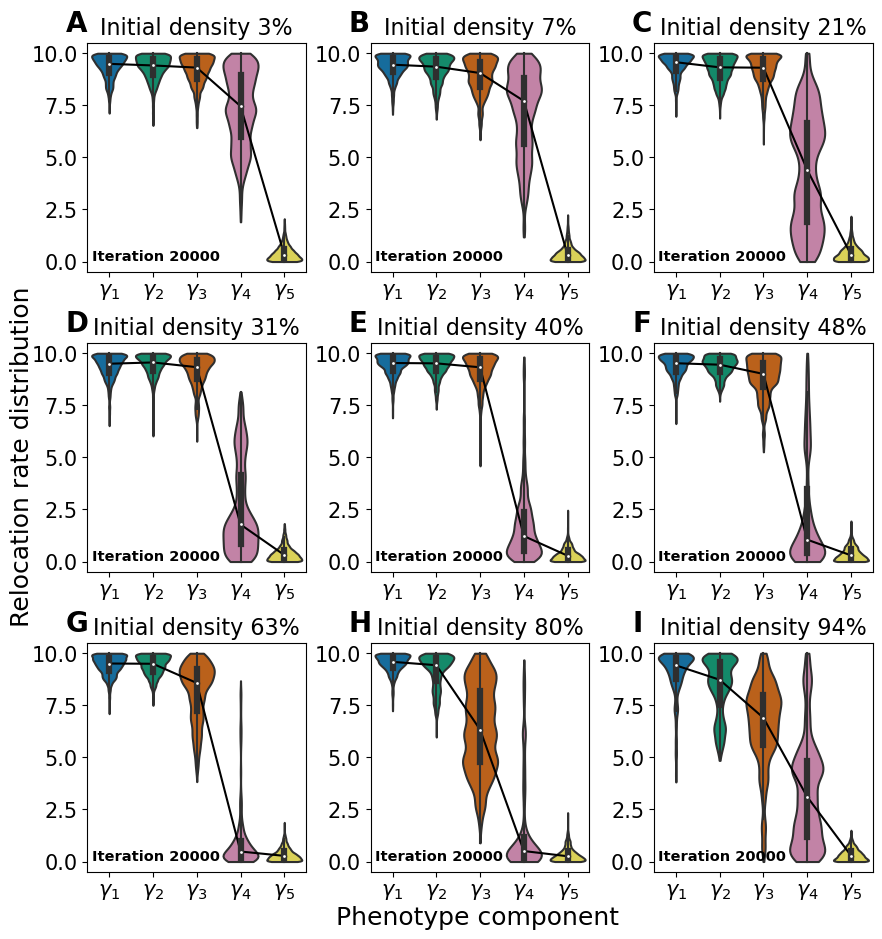

In [342]:
# coexistence of phenotypes on density 21% 31% violin plots
df = []
for i in [3,7,21, 31,40,48,63,80,94]:
    data = [[] for _ in range(20)]
    boxdata = []
    for j in range(20):
        try:
            with open("./evolve_data/high_density/density_{}/trial_{}/iteration_20000".format(i, j), "rb") as fp:   # Unpickling
                data[j] = pickle.load(fp)
        except FileNotFoundError:
            print("trial_{}".format(j)+" doesn\'t have iteration_{}".format(i))
        else:
            boxdata.append(np.array([data[j][i].hop for i in range(500)]))
    df.append(pd.DataFrame(np.array(boxdata).reshape(10000, 5), columns=(
        '$\gamma_1$', r'$\gamma_2$', r'$\gamma_3$', r'$\gamma_4$', r'$\gamma_5$')))
fig, ax = plt.subplots(ncols=3, nrows=3, constrained_layout=True,dpi=100,figsize=(8.5,9))

for i in range(9):
    ax[i//3,i%3].plot(df[i].median(), color='k', label='Simulated')
    sns.violinplot(data=df[i], scale='width', inner='box', cut=0, ax=ax[i//3,i%3])
    ax[i//3,i%3].text(-0.1, 1.05, string.ascii_uppercase[i], transform=ax[i//3,i%3].transAxes,
               size=20, weight='bold')
    ax[i//3,i%3].text(0.02, 0.05, "Iteration 20000", transform=ax[i//3,i%3].transAxes,
               size=10.5, weight='bold')
    ax[i//3,i%3].set_title('Initial density {}%'.format([3,7,21, 31,40,48,63,80,94][i]), fontsize=16)
    ax[i//3,i%3].tick_params(axis='x', labelsize=15)
    ax[i//3,i%3].tick_params(axis='y', labelsize=15)
#     ax[i//3,i%3].set_xlabel("Phenotype component", fontsize=12)
#     ax[i//3,i%3].set_ylabel("Relocation rate distribution",
#                      color=color, fontsize=12)
fig.text(-0.02, 0.5, 'Relocation rate distribution',
         fontsize=18, va='center', rotation='vertical')
fig.text(0.53, -0.02, 'Phenotype component', fontsize=18, ha='center')
fig.savefig('./Figures/Supplementary_high_density_violin.pdf', bbox_inches='tight')

In [21]:
# supplementary figures

# occupancy after catastrophe for different densities to see high occupancy on high resource levels, dynamics scarcity of site introduced by density, compared to the built-in exponential resource

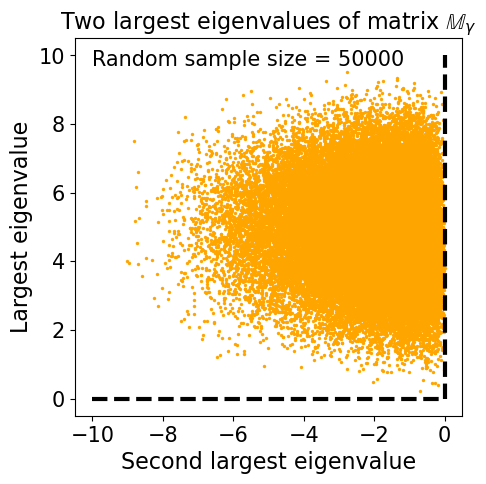

In [537]:
c = 0
p0 = [np.exp(-c*i) for i in range(5)]
w = p0/np.sum(p0)

def max_eigen2(h, b):
    """Generate the coefficient matrix and calculate the largest two eigenvalues"""
    m = np.outer(w, np.array(b)+np.array(h))-np.diag(h)
    return np.sort(LA.eig(m)[0])[-2:][::-1]

def plot_largest2eigenvalues(sample_size=100000, random_birth_rate=False,savefig=False):
    """Plot the scatter plot of the largest 2 eigenvalues for randomly generated hopping rate with or without random birth rate"""      
    eigen = [max_eigen2(np.random.rand(5)*10, b=np.random.rand(5)*10 if random_birth_rate else [0,1,2,3,4] ) for _ in range(sample_size)]
    fig = plt.figure(dpi=100, figsize=(5, 5))
    ax = plt.subplot()
    sc = ax.scatter(np.array(eigen)[:, 1], np.array(
        eigen)[:, 0], s=2, color='orange')
    ax.vlines(0, 0, 10, linestyles='dashed', lw=3, color='k')
    ax.hlines(0, -10, 0, linestyles='dashed', lw=3, color='k')
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_title(
        'Two largest eigenvalues of matrix $\mathbb{M}_\gamma}$', fontsize=16)
    ax.text(-10, 9.7, 'Random sample size = {}'.format(sample_size), fontsize=15)
    plt.xlabel("Second largest eigenvalue", fontsize=16)
    plt.ylabel("Largest eigenvalue", fontsize=16)
    if savefig:
        fig.savefig('./Figures/Figure_6_eigenvalues.pdf', bbox_inches='tight')
    plt.show()

plot_largest2eigenvalues(sample_size=50000, random_birth_rate=True,savefig=True)

## Site occupancy

In [112]:
def get_num(a, n):
    """
    Efficiently count agent numbers at all the sites

        Parameters: 
            a (list or array): list of agent object;
            n (int): size of the square environment
       Return:
            2-d numpy array: entry at i,j represents the number of agent at location (i,j)
    """
    num = np.zeros((n, n), dtype=int)
    for pos in [a[i].__dict__['pos'] for i in range(len(a))]:
        num[pos] += 1
    return num


meanoccupancy = []
stdoccupancy = []
for size, density in [(128, 3),
                      (96, 5),
                      (80, 7),
                      (64, 12),
                      (48, 21),
                      (40, 31),
                      (35, 40),
                      (32, 48),
                      (28, 63),
                      (26, 73),
                      (25, 80),
                      (24, 86),
                      (23, 94)]:
    # [(128,3),(80,7),(64,12),(48,21),(32,48),(25,80),(23,94)]:
    with open("./evolve_data/high_density/density_{}/trial_{}/resource.txt".format(density, 0), "rb") as fp:   # Unpickling
        resource = pickle.load(fp)[:size, :size]
    empty_array = np.empty((size, size))
    empty_array[:] = np.NaN
    occupancy = []
    for iteration in range(18000, 20001, 50):
        unoccupied_trial = []
        for j in range(20):
            with open("./evolve_data/high_density/density_{}/trial_{}/iteration_{}".format(density, j, iteration), "rb") as fp:   # Unpickling
                data = pickle.load(fp)
            unoccupied = np.where(get_num(data, size), empty_array, resource)
            unoccupied_trial.append(np.bincount([int(i) for i in unoccupied.flatten(
            ) if not np.isnan(i)], minlength=5))#/np.bincount(resource.flatten(), minlength=5))
        occupancy.append(np.mean(unoccupied_trial, 0))
    meanoccupancy.append(np.mean(np.array(occupancy), 0))
    stdoccupancy.append(np.std(np.array(occupancy), 0))

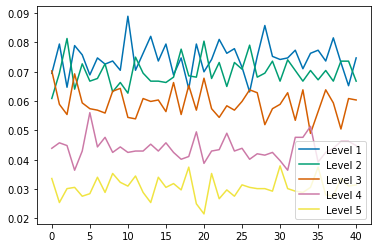

In [24]:
for i in range(5):
    plt.plot(np.array(occupancy)[:,i],label='Level {}'.format(i+1))
plt.legend()

In [25]:
# for i in range(13):
#     fig,ax=plt.subplots(dpi=100)
#     bp=ax.bar([0,1,2,3,4],meanoccupancy[i])
#     plt.ylim(0,1)
#     plt.text(1,0.2,'Initial density = {}'.format([(128, 3),
#                       (96, 5),
#                       (80, 7),
#                       (64, 12),
#                       (48, 21),
#                       (40, 31),
#                       (35, 40),
#                       (32, 48),
#                       (28, 63),
#                       (26, 73),
#                       (25, 80),
#                       (24, 86),
#                       (23, 94)][i][1]),fontsize=20)
#     ax.bar_label(bp)
#     ax.set_xlabel("Resource levels",fontsize=16)
#     ax.set_ylabel("Percentage of unoccupied sites",fontsize=16)
#     plt.show()

In [114]:
err_ratio = [meanoccupancy[i][-1]/meanoccupancy[i][0]*np.sqrt((stdoccupancy[i][-1]/meanoccupancy[i][-1])**2+(stdoccupancy[i][0]/meanoccupancy[i][0])**2) for i in range(13)]

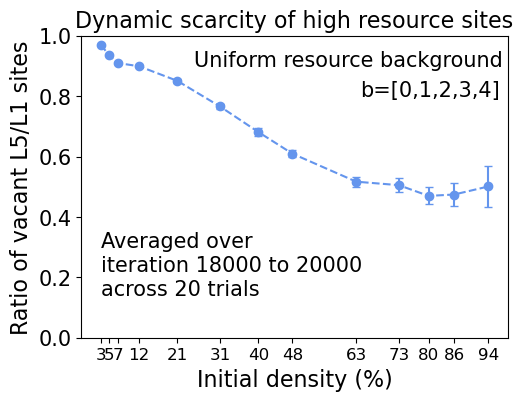

In [115]:
fig,ax=plt.subplots(dpi=100,figsize=(5.5,4))
ax.scatter([3, 5, 7, 12, 21, 31, 40, 48, 63, 73, 80, 86, 94],[meanoccupancy[i][-1]/meanoccupancy[i][0] for i in range(13)],color='cornflowerblue')
ax.errorbar([3, 5, 7, 12, 21, 31, 40, 48, 63, 73, 80, 86, 94],[meanoccupancy[i][-1]/meanoccupancy[i][0] for i in range(13)],
                  yerr=err_ratio, capsize=3, linestyle='--',color='cornflowerblue')
ax.set_xticks([3, 5, 7, 12, 21, 31, 40, 48, 63, 73, 80, 86, 94]);
ax.set_xlabel('Initial density (%)',fontsize=16)
ax.set_ylabel('Ratio of vacant L5/L1 sites',fontsize=16)
ax.set_title('Dynamic scarcity of high resource sites',fontsize=16)
ax.set_ylim(0,1)
ax.text(25,0.9,"Uniform resource background",fontsize=15)
ax.text(64,0.8,"b=[0,1,2,3,4]",fontsize=15)
ax.text(3,0.3,"Averaged over",fontsize=15)
ax.text(3,0.22,"iteration 18000 to 20000",fontsize=15)
ax.text(3,0.14,"across 20 trials",fontsize=15)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=15)
# fig.savefig('./Figures/Supplementary_density_scarcity.pdf', bbox_inches='tight')

In [116]:
def get_num(a, n):
    """
    Efficiently count agent numbers at all the sites

        Parameters: 
            a (list or array): list of agent object;
            n (int): size of the square environment
       Return:
            2-d numpy array: entry at i,j represents the number of agent at location (i,j)
    """
    num = np.zeros((n, n), dtype=int)
    for pos in [a[i].__dict__['pos'] for i in range(len(a))]:
        num[pos] += 1
    return num


meanoccupancy = []
stdoccupancy = []
for c in [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:

    with open("./evolve_data/b5_c_plane/b5_4_c_{}/trial_{}/resource.txt".format(c, 0), "rb") as fp:   # Unpickling
        resource = pickle.load(fp)
    empty_array = np.empty((128,128))
    empty_array[:] = np.NaN
    occupancy = []
    for iteration in range(16000, 20001, 1000):
        unoccupied_trial = []
        for j in range(20):
            with open("./evolve_data/b5_c_plane/b5_4_c_{}/trial_{}/iteration_{}".format(c, j, iteration), "rb") as fp:   # Unpickling
                data = pickle.load(fp)
            unoccupied = np.where(get_num(data, 128), empty_array, resource)
            unoccupied_trial.append(np.bincount([int(i) for i in unoccupied.flatten(
            ) if not np.isnan(i)], minlength=5)/np.bincount(resource.flatten(), minlength=5))
        occupancy.append(np.mean(unoccupied_trial, 0))
    meanoccupancy.append(np.mean(np.array(occupancy), 0))
    stdoccupancy.append(np.std(np.array(occupancy), 0))

In [104]:
with open("./evolve_data/b5_c_plane/b5_5_c_{}/trial_{}/resource.txt".format(1.0, 0), "rb") as fp:   # Unpickling
    resource = pickle.load(fp)
np.bincount(resource.flatten(), minlength=5)

array([10349,  3870,  1450,   523,   192])

In [97]:
with open("./evolve_data/b5_c_plane/b5_5_c_{}/trial_{}/iteration_{}".format(0, j, iteration), "rb") as fp:   # Unpickling
    data = pickle.load(fp)
unoccupied = np.where(get_num(data, 128), empty_array, resource)
np.bincount([int(i) for i in unoccupied.flatten(
) if not np.isnan(i)], minlength=5)/np.bincount(resource.flatten(), minlength=5)

array([0.97214326, 0.96589582, 0.96788092, 0.97135582, 0.96712619])

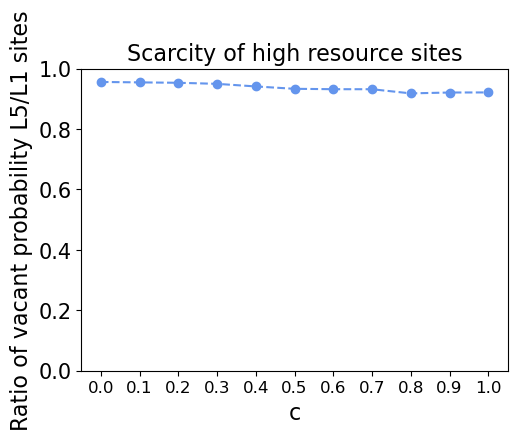

In [117]:
err_ratio = [meanoccupancy[i][-1]/meanoccupancy[i][0]*np.sqrt((stdoccupancy[i][-1]/meanoccupancy[i][-1])**2+(stdoccupancy[i][0]/meanoccupancy[i][0])**2) for i in range(11)]
fig,ax=plt.subplots(dpi=100,figsize=(5.5,4))
ax.scatter([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],[meanoccupancy[i][-1]/meanoccupancy[i][0] for i in range(11)],color='cornflowerblue')
ax.errorbar([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],[meanoccupancy[i][-1]/meanoccupancy[i][0] for i in range(11)],
                  yerr=err_ratio, capsize=3, linestyle='--',color='cornflowerblue')
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]);
ax.set_xlabel('c',fontsize=16)
ax.set_ylabel('Ratio of vacant probability L5/L1 sites',fontsize=16)
ax.set_title('Scarcity of high resource sites',fontsize=16)
ax.set_ylim(0,1)
# ax.text(25,0.9,"Exponential resource background",fontsize=15)
# ax.text(64,0.8,"b=[0,1,2,3,4]",fontsize=15)
# ax.text(3,0.3,"Averaged over",fontsize=15)
# ax.text(3,0.22,"iteration 16000 to 20000",fontsize=15)
# ax.text(3,0.14,"across 20 trials",fontsize=15)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=15)
# fig.savefig('./Figures/Supplementary_density_scarcity.pdf', bbox_inches='tight')

# Reproduction noise

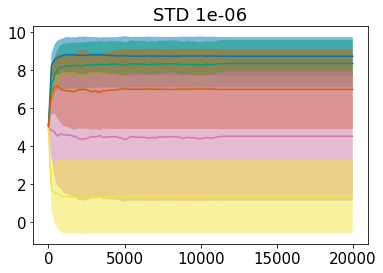

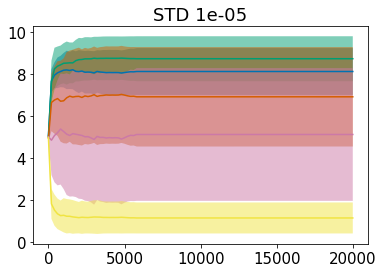

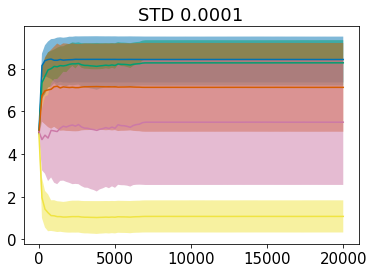

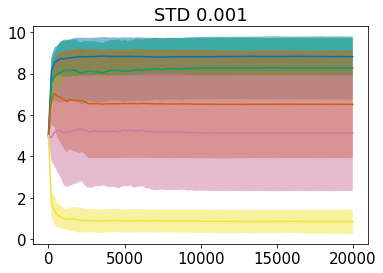

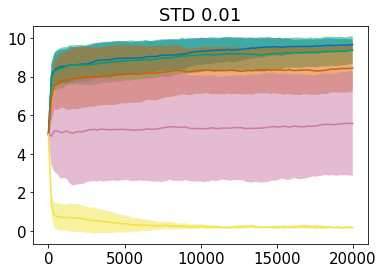

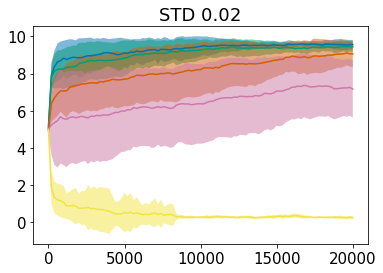

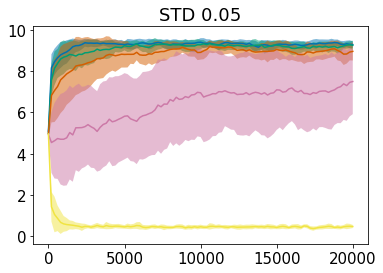

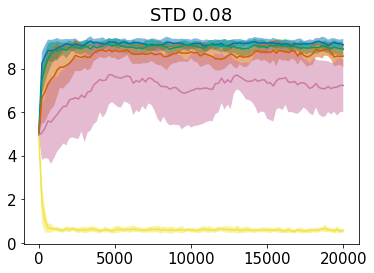

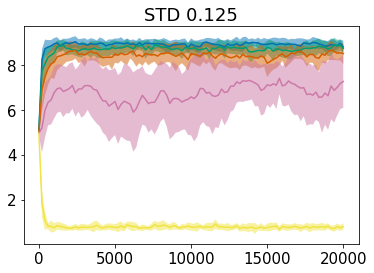

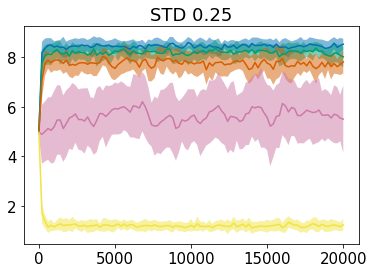

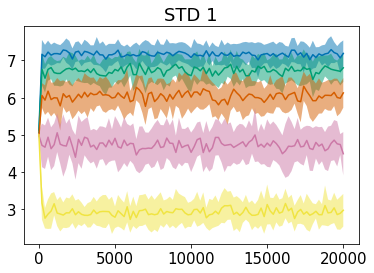

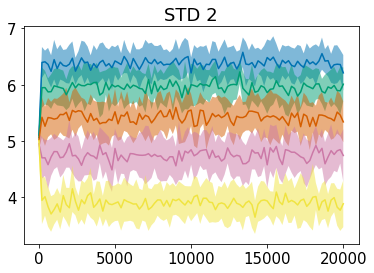

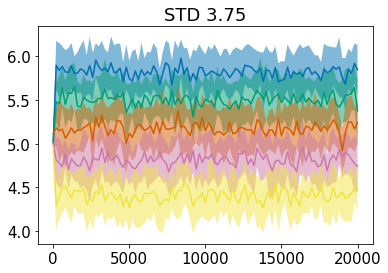

In [211]:
ave_h4=[]
std_h4=[]
for noise in ['1e-06','1e-05',0.0001,0.001, 0.01,0.02,0.05,0.08,0.125,0.25,1,2,3.75]:
    iteration =20001
    var_standard=[[] for _ in range(len(range(0,iteration,200)))]
    ave_standard=[[] for _ in range(len(range(0,iteration,200)))]
    for i in range(0,iteration,200):
        data=[[] for _ in range(20)]

        boxdata=[]
        for j in range(20):
            try:
                with open("./evolve_data/noise_std/std_{}_with_agents_number/trial_{}/iteration_{}".format(noise,j,i), "rb") as fp:   # Unpickling
                    data[j] = pickle.load(fp)
            except FileNotFoundError:
                print("trial_{}".format(j)+" doesn\'t have iteration_{}".format(i))
            else:
                boxdata.append(np.average(np.array([data[j][i].hop for i in range(500)]),axis=0))
        var_standard[int(i/200)]=np.var(np.array(boxdata).T,1)
        ave_standard[int(i/200)]=np.average(np.array(boxdata).T,1)
        
    for i in range(5):
        plt.plot(np.linspace(0, 20000, 101), np.array(ave_standard)[
                   :, i], '-', label="$\gamma_{}$".format(i+1))
        plt.fill_between(np.linspace(0, 20000, 101), np.array(ave_standard)[
                               :, i]-np.sqrt(np.array(var_standard))[:, i], np.array(ave_standard)[:, i]+np.sqrt(np.array(var_standard))[:, i], alpha=0.5)
    # plt.set_ylabel('Mean relocation rate', fontsize=18)
    # plt.set_xlabel('Iteration', fontsize=18)
    plt.title('STD {}'.format(noise), fontsize=18)
#     plt.legend(loc='lower right', bbox_to_anchor=(
#         0.95, 0.07), frameon=False, fontsize=12)
    # plt.set_ylim(-0.5, 10.5)
    # plt.set_xticks([0, 5000, 10000, 15000, 20000])
    # plt.set_yticks([0, 2, 4, 6, 8, 10])
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    plt.show()
    ave_h4.append(np.array(ave_standard)[:,-2])
    std_h4.append(np.sqrt(np.array(var_standard)[:,-2]))

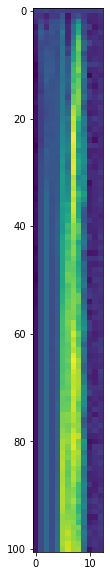

In [209]:
fig = plt.figure(figsize=(50,10))
plt.imshow(np.array(ave_h4).T)

In [129]:
np.array(ave_h4)[:,-1]

array([6.52947167, 5.89533435, 7.30048051, 7.20648854, 6.55626588,
       5.91651165, 4.85053185, 4.65697449, 4.77041875])

In [141]:
with open("./evolve_data/noise_std/std_{}_with_agents_number/trial_{}/total_agents_before_catastrophe".format(0.01,10), "rb") as fp:   # Unpickling
    total_agents = pickle.load(fp)

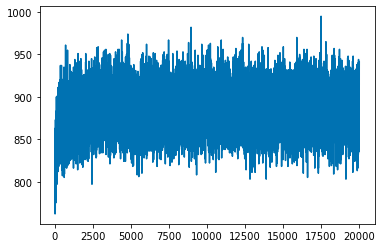

In [134]:
plt.plot(total_agents)

In [136]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

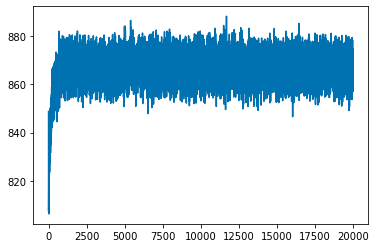

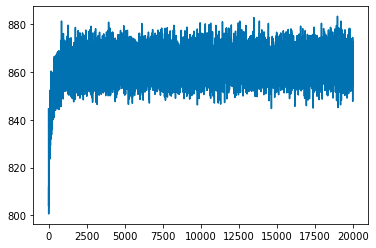

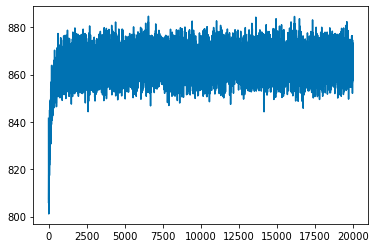

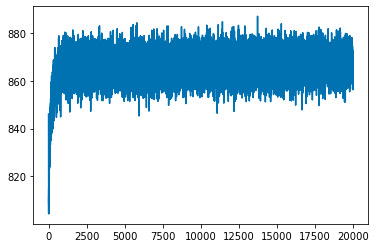

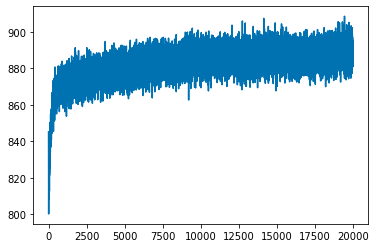

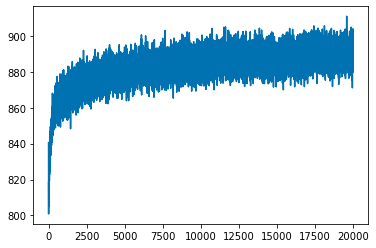

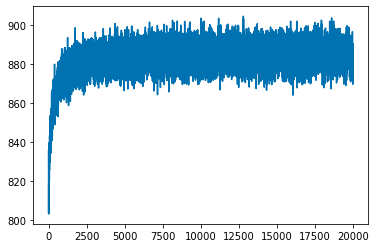

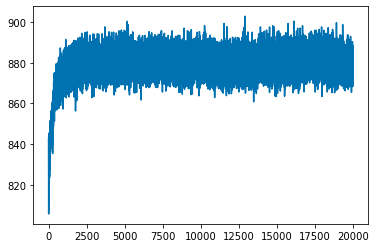

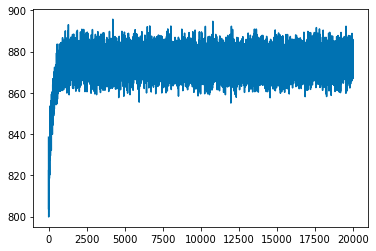

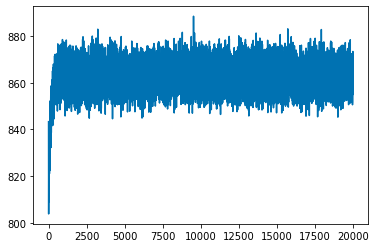

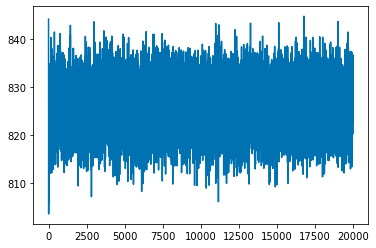

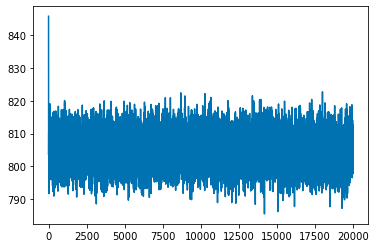

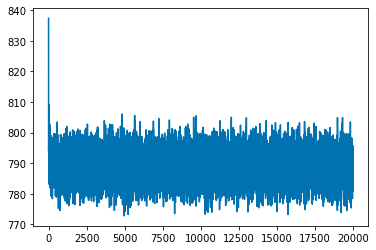

In [195]:
last_fitness=[]
last_std=[]
for noise in ['1e-06','1e-05',0.0001,0.001, 0.01,0.02,0.05,0.08,0.125,0.25,1,2,3.75]:
    data=[[] for _ in range(20)]
    for j in range(20):
        with open("./evolve_data/noise_std/std_{}_with_agents_number/trial_{}/total_agents_before_catastrophe".format(noise,j), "rb") as fp:   # Unpickling
            data[j] = pickle.load(fp)
    last_fitness.append(np.mean(np.mean(np.array(data),0)[-1000:]))
    last_std.append(np.std(np.mean(np.array(data),0)[-1000:]))
    plt.plot(np.mean(np.array(data),0))
    plt.show()

Text(0, 0.5, 'Reproduced offspring # (fitness)')

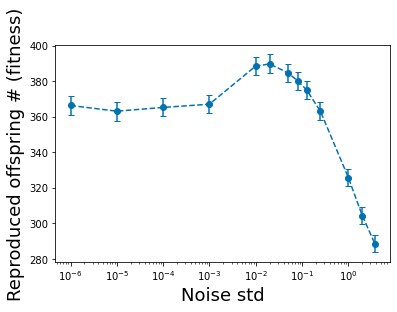

In [202]:
ax = plt.subplot()
ax.set_xscale('log')
ax.scatter([0.000001,0.00001,0.0001,0.001,0.01,0.02,0.05,0.08,0.125,0.25,1,2,3.75],np.array(last_fitness)-500)
ax.errorbar([0.000001,0.00001,0.0001,0.001,0.01,0.02,0.05,0.08,0.125,0.25,1,2,3.75],np.array(last_fitness)-500,last_std, capsize=3, linestyle='--')
ax.set_xlabel('Noise std',fontsize=18)
ax.set_ylabel('Reproduced offspring # (fitness)',fontsize=18)

## Supplementary: stochastic simulation of 5-state model --> quicker convergence

In [407]:
import random
import math
class Agent_5_states:
    def __init__(self,h1,h2,h3,h4,h5,loc=None):

        self.hop = (h1,h2,h3,h4,h5);
        self.pos = loc;
        self.b = resource[int(loc)]; # resource goes as 0, 1, 2, 3, 4, 5
        self.h = self.hop[int(loc)]; 

    def updatepos(self,loc):
        self.pos = loc;
        self.b = resource[int(loc)]; # resource goes as 0, 1, 2, 3, 4, 5
        self.h = self.hop[int(loc)]; 
        
def get_i(x,arr,l,r): # binary search for i
    if x < arr[0]:
        return 0
    else:
        while l <= r: 

            mid = l + int((r - l)/2); 

            # Check if x is present at mid 
            if arr[mid] <= x and arr[mid+1] >= x: 
                return mid+1 

            # If x is greater, ignore left half 
            elif arr[mid+1] <= x: 
                l = mid + 1

            # If x is smaller, ignore right half 
            else: 
                r = mid

        # If we reach here, then the element was not present 
        return -1
def noisy_hop(hop,sigma):
    new_hop=hop+np.random.normal(0,sigma,len(hop))
    new_hop[new_hop<0]=0
    new_hop[new_hop>10]=10
    return new_hop

def evolve_5_state(T=0.3,agent_num=500,iterations=100,noise=0.05,prob=[0.2,0.2,0.2,0.2,0.2]):
    h_initial=[np.random.uniform(0,10,agent_num) for _ in range(5)]
    loc_initial=np.random.choice([0,1,2,3,4],agent_num)
    a=[Agent_5_states(q,w,e,r,t,k) for q,w,e,r,t,k in zip(*h_initial,loc_initial)]
    hop_data=[]
#     stdhop=[]
    for j in range(iterations):
        t = 0
        br = [a[i].b for i in range(len(a))]
        hr = [a[i].h for i in range(len(a))]
        brsum = sum(br)
        w = brsum + sum(hr) # total rates
        
        br_cumsum=np.cumsum(br)
        hr_cumsum=np.cumsum(hr)
        while t < T: 
            dt = -math.log(random.uniform(0.0,1.0)) / w
            t = t + dt
            r = w * random.uniform(0.0,1.0)

            if r < brsum: # birth
                i = get_i(r,br_cumsum,0,len(a)-1)
                to = np.random.choice([0,1,2,3,4],p=prob)
                a.append(Agent_5_states(*noisy_hop(a[i].hop,sigma=noise),to))
                br.append(a[-1].b)
                hr.append(a[-1].h)
                brsum+=a[-1].b
                w+=a[-1].b+a[-1].h
                br_cumsum=np.append(br_cumsum,a[-1].b+br_cumsum[-1])
                hr_cumsum=np.append(hr_cumsum,a[-1].h+hr_cumsum[-1])
            else: # hop
                i = get_i(r,brsum+hr_cumsum,0,len(a)-1)
                to = np.random.choice([0,1,2,3,4],p=prob)
                a[i].updatepos(to)
                brsum+=a[i].b-br[i]
                w+=a[i].b-br[i]+a[i].h-hr[i]
                br_cumsum[i:]+=a[i].b-br[i]
                hr_cumsum[i:]+=a[i].h-hr[i]
                br[i]=a[i].b
                hr[i]=a[i].h

        reset = random.sample(range(len(a)), agent_num) # randomly generate m agents to keep for the next iteration
        a = [a[i] for i in reset]
        hop_data.append(np.array([a[i].hop for i in range(len(a))])) # save the average hopping rate after each iteration
#         stdhop.append(np.std(np.array([a[i].hop for i in range(len(a))]),0))
    return hop_data

Text(-0.12, 1.05, 'C')

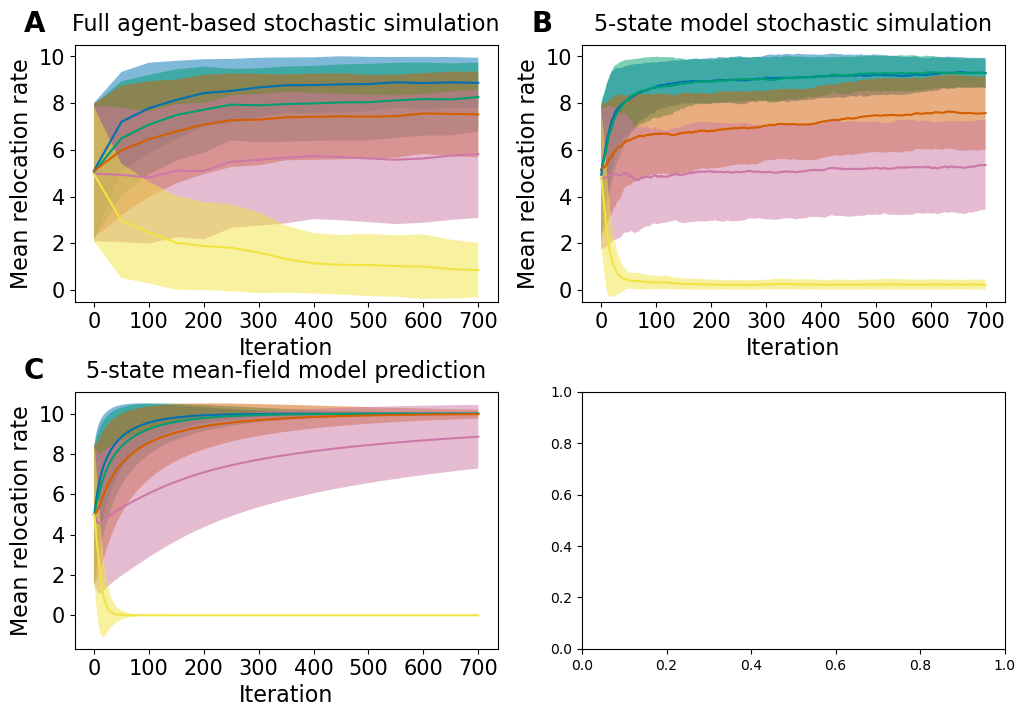

In [458]:
fig, ax = plt.subplots(2, 2, dpi=100, figsize=(12, 8), gridspec_kw=dict(width_ratios=[1, 1], height_ratios=[
                       1, 1], hspace=0.35, wspace=0.2))

iteration = 701
iter_interval = 50
std_standard = [[] for _ in range(len(range(0, iteration, iter_interval)))]
ave_standard = [[] for _ in range(len(range(0, iteration, iter_interval)))]
for i in range(0, iteration, iter_interval):
    data = [[] for _ in range(20)]

    boxdata = []
    for j in range(20):
        try:
            with open("./evolve_data/2021_04_08_21_48/trial_{}/iteration_{}".format(j, i), "rb") as fp:   # Unpickling
                data[j] = pickle.load(fp)
        except FileNotFoundError:
            print("trial_{}".format(j)+" doesn\'t have iteration_{}".format(i))
        else:
            boxdata.append(np.array([data[j][i].hop for i in range(500)]))
    std_standard[int(i/iter_interval)] = np.std(np.vstack(boxdata), 0)
    ave_standard[int(i/iter_interval)] = np.mean(np.vstack(boxdata), 0)

for i in range(5):
    ax[0, 0].plot(np.linspace(0, iteration-1, int(iteration/iter_interval)+1), np.array(ave_standard)[
        :, i], '-', label="$\gamma_{}$".format(i+1))
    ax[0, 0].fill_between(np.linspace(0, iteration-1, int(iteration/iter_interval)+1), np.array(ave_standard)[
        :, i]-np.array(std_standard)[:, i], np.array(ave_standard)[:, i]+np.array(std_standard)[:, i], alpha=0.5)

ax[0, 0].set_title('Full agent-based stochastic simulation',
                   fontsize=16, pad=10)
ax[0, 0].set_ylabel('Mean relocation rate', fontsize=16)
ax[0, 0].set_xlabel('Iteration', fontsize=16)
ax[0, 0].set_ylim(-0.5, 10.5)
ax[0, 0].set_xticks([0, 100, 200, 300, 400, 500, 600, 700])
ax[0, 0].set_yticks([0, 2, 4, 6, 8, 10])
ax[0, 0].tick_params(axis='x', labelsize=15)
ax[0, 0].tick_params(axis='y', labelsize=15)
ax[0, 0].text(-0.12, 1.05, 'A', transform=ax[0, 0].transAxes,
              size=20, weight='bold')


resource=[0,1,2,3,5]
sigma = 0.05 
ave_copies=[]
from concurrent.futures import ProcessPoolExecutor
with ProcessPoolExecutor() as executor:
    test = [executor.submit(evolve_5_state,agent_num=500,iterations=701,noise=sigma) for i in range(20)]
target = np.concatenate([test[i].result() for i in range(20)],1)
ave=np.mean(target,1)
std=np.std(target,1)
for i in range(5):
    ax[0, 1].plot(ave[:,i],label="$\gamma_{}$".format(i+1))
    ax[0, 1].fill_between(range(701),np.array(ave)[:,i]-np.array(std)[:,i], np.array(ave)[:,i]+np.array(std)[:,i],alpha=0.5)

ax[0, 1].set_title('5-state model stochastic simulation',fontsize=16, pad=10)
ax[0, 1].set_ylabel('Mean relocation rate', fontsize=16)
ax[0, 1].set_xlabel('Iteration', fontsize=16)
ax[0, 1].set_ylim(-0.5, 10.5)
ax[0, 1].set_xticks([0, 100, 200, 300, 400, 500, 600, 700])
ax[0, 1].set_yticks([0, 2, 4, 6, 8, 10])
ax[0, 1].tick_params(axis='x', labelsize=15)
ax[0, 1].tick_params(axis='y', labelsize=15)
ax[0, 1].text(-0.12, 1.05, 'B', transform=ax[0, 1].transAxes,
              size=20, weight='bold')

with open('./evolve_data/mean_field_high_density/density_{}'.format(3), "rb") as fp:
        full_sol = pickle.load(fp)
ave,std= cal_average_std(full_sol.reshape(-1,5,2001)[:,:,:701],701,hoppings=hopping_discrete)
t_eval= np.linspace(0,700,701)
for i in range(5):
    ax[1, 0].plot(t_eval,np.array(ave)[:,i],label="$\gamma_{}$".format(i+1))
    ax[1, 0].fill_between(t_eval,np.array(ave)[:,i]-np.array(std)[:,i], np.array(ave)[:,i]+np.array(std)[:,i], alpha=0.5)
ax[1, 0].set_title('5-state mean-field model prediction',
                   fontsize=16, pad=10)
ax[1, 0].set_ylabel('Mean relocation rate', fontsize=16)
ax[1, 0].set_xlabel('Iteration', fontsize=16)
# ax[1, 0].set_ylim(-1, 11)
ax[1, 0].set_xticks([0, 100, 200, 300, 400, 500, 600, 700])
ax[1, 0].set_yticks([0, 2, 4, 6, 8, 10])
ax[1, 0].tick_params(axis='x', labelsize=15)
ax[1, 0].tick_params(axis='y', labelsize=15)
ax[1, 0].text(-0.12, 1.05, 'C', transform=ax[1, 0].transAxes,
              size=20, weight='bold')
